# Import and boiler plate code

In [164]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random 
import torch
from torch import autograd
import torch.nn.functional as F
import time
import math
from skimage import io,transform as sk_transform


Importing and Preparing Data

In [165]:
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
label_ids,count=np.unique(labels,return_counts=True)
print(label_ids,count)


(array([0, 1, 2, 3, 4], dtype=uint8), array([10000, 10000, 10000, 10000, 10000]))


In [166]:
shape_images_flat=(images.shape[0],images.shape[1]*images.shape[2])
images_normal=np.ndarray(shape=shape_images_flat)

# normalizing and flattening images
for index in range(len(images)):
    images_normal[index]=((images[index]-images[index].mean())/images[index].std()).flat

#  braking data set into train,validation and test sets
train_images=images_normal[0:45000]
train_labels=labels[0:45000]

validation_images=images_normal[45000:50000]
validation_labels=labels[45000:50000]

test_images=images_normal[45000:50000]
test_labels=labels[45000:50000]



In [167]:
def accuracy(y, y_hat):
    a=(y==y_hat)
    return a.astype(np.float).mean()

In [168]:
def approx_accuracy(curr_images,curr_labels,length=-1):
    if length==-1:
        length=len(curr_images)
        
    shuffle_list=np.random.choice(len(curr_images), length)
    shuffled_images=curr_images[shuffle_list]
    shuffled_labels=curr_labels[shuffle_list]
    
    x = autograd.Variable(torch.from_numpy(shuffled_images.astype(np.float32))).cuda()
    y = autograd.Variable(torch.from_numpy(shuffled_labels.astype(np.int))).cuda()
    _,y_hat =torch.max(model(x),1)
    # print(y_hat.size())
    return accuracy(y.cpu().data.numpy(), y_hat.cpu().data.numpy())
         

In [192]:
def random_augment_image(images):
    
    for i in xrange(0,images.shape[0]):
        image=images[i]
        image=image.reshape(26,26)
        # print(image.shape)
        ## mirror flipping
        flip_probab = random.random()
        if flip_probab <=0.8:
            image = np.fliplr(image)

        # rotate image parmaeter:
        angle = math.radians(random.randrange(-30, +30))
        
        # translate image parameter
        tr_distance_x = random.randrange(-3, +3)
        tr_distance_y = random.randrange(-3, +3)
        # scaling image parameter
        scaling_val=random.uniform(0.7,1.3) 
        
        tform=sk_transform.SimilarityTransform(scale=scaling_val, rotation=angle,\
                                                    translation=(tr_distance_x, tr_distance_y))
        # transform probabilty 
        tr_probab= random.random()
        if tr_probab<=0.8:
            image = sk_transform.warp(image,inverse_map=tform)        
        images[i]=image.flat
    return images

In [193]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_images.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(random_augment_image(train_images[i]).astype(np.float32))).cuda()
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int))).cuda()
    
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y).cuda()
    loss.backward()
    
    optimizer.step()
    return loss.data[0]


##  BEST MODEL

In [194]:
batch_size=60
learning_rate=1e-3
NUM_OPT_STEPS=30000

HEIGHT,WIDTH=26,26
NUM_CLASSES=5
NUM_HIDDEN_UNITS_1=500
NUM_HIDDEN_UNITS_2=100
NUM_HIDDEN_UNITS_3=50
# NUM_OPT_STEPS=train_labels.shape[0]/batch_size

In [182]:
class Best_Model(torch.nn.Module):
    def __init__(self):
        super(Best_Model,self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3,stride=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.fc1 = torch.nn.Linear( 3200, NUM_HIDDEN_UNITS_1)
        self.fc2 = torch.nn.Linear(NUM_HIDDEN_UNITS_1, NUM_HIDDEN_UNITS_2)
        self.fc3 = torch.nn.Linear(NUM_HIDDEN_UNITS_2, NUM_CLASSES)
        self.drop_1 = torch.nn.Dropout(p=0.7)
        self.F_max_pool2d = F.max_pool2d
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
      
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x= self.F_max_pool2d(x,3)
        x = F.relu(self.conv3(x))
        n, c, h, w = x.size()
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

In [183]:
model=Best_Model().cuda()
print(model)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


Best_Model (
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear (3200 -> 500)
  (fc2): Linear (500 -> 100)
  (fc3): Linear (100 -> 5)
)


In [184]:
train_accs, val_accs,test_accs = [], [] ,[]
start=time.time()

for i in range(NUM_OPT_STEPS):
    train(batch_size)    
    if i % 1000 == 0:
        train_accs.append(approx_accuracy(train_images,train_labels,1000))
        val_accs.append(approx_accuracy(validation_images,validation_labels))
        test_accs.append(approx_accuracy(test_images,test_labels))
    if i%1000 == 0:
        print("%6d %5.3f %5.3f %5.3f" % ( i, train_accs[-1], val_accs[-1],test_accs[-1]))

end=time.time()
print('Time taken', end-start)

     0 0.207 0.182 0.188
  1000 0.907 0.908 0.907
  2000 0.937 0.933 0.930
  3000 0.929 0.928 0.926
  4000 0.944 0.937 0.931
  5000 0.950 0.945 0.942
  6000 0.941 0.947 0.943
  7000 0.961 0.954 0.944
  8000 0.964 0.952 0.946
  9000 0.966 0.944 0.944
 10000 0.970 0.949 0.942
 11000 0.967 0.947 0.945
 12000 0.966 0.950 0.951
 13000 0.974 0.953 0.954
 14000 0.977 0.951 0.946
 15000 0.970 0.952 0.951
 16000 0.974 0.945 0.946
 17000 0.966 0.964 0.955
 18000 0.967 0.949 0.950
 19000 0.981 0.957 0.949
 20000 0.982 0.953 0.953
 21000 0.976 0.954 0.952
 22000 0.979 0.948 0.949
 23000 0.979 0.954 0.954
 24000 0.979 0.956 0.956
 25000 0.983 0.953 0.951
 26000 0.988 0.949 0.952
 27000 0.978 0.948 0.946
 28000 0.977 0.959 0.951
 29000 0.981 0.952 0.953
('Time taken', 540.7133657932281)


 29999  0.98  0.95


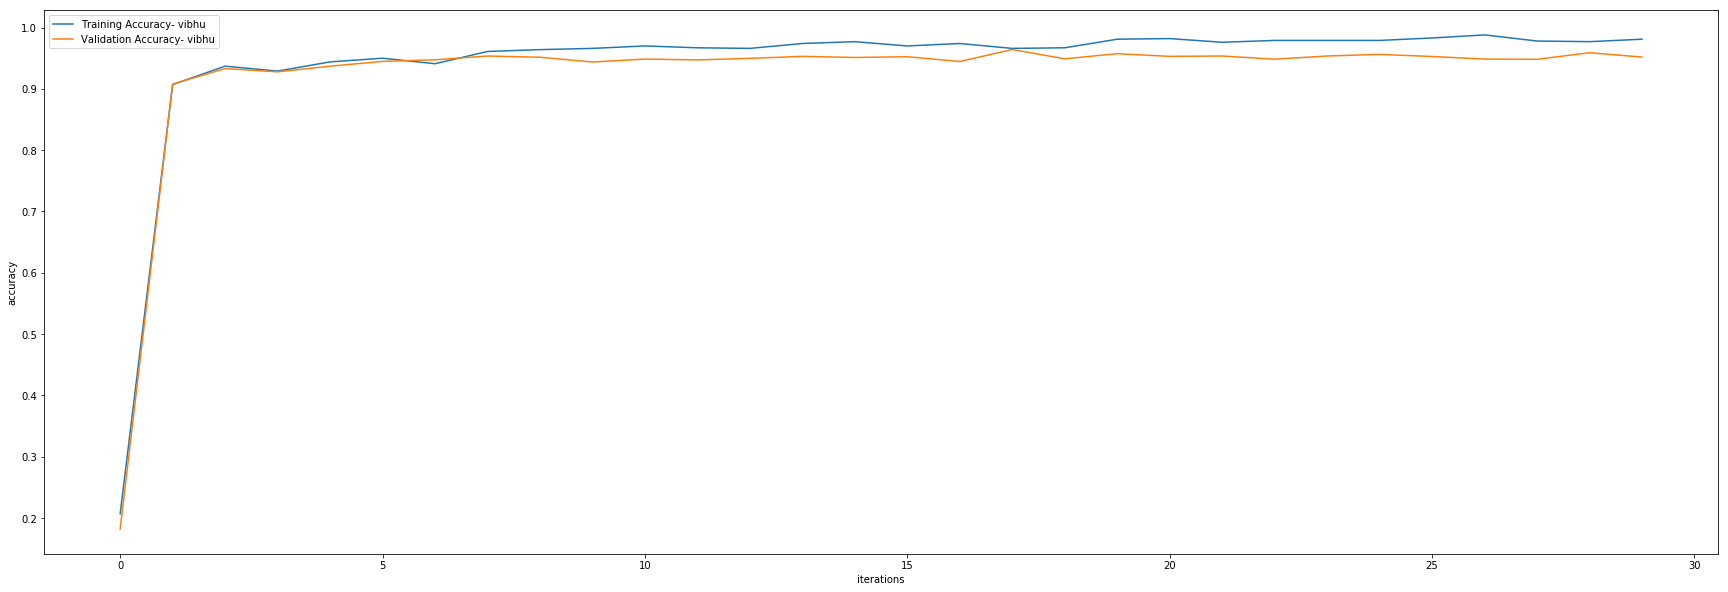

In [186]:
print("%6d %5.2f %5.2f" % ( i, train_accs[-1], val_accs[-1]))
plt.figure(figsize=(30, 10))
plt.xlabel('iterations')
plt.ylabel('accuracy')
training_accuracy_line,=plt.plot(train_accs,label='Training Accuracy- vibhu ')
validation_accuracy_line,=plt.plot(val_accs,label='Validation Accuracy- vibhu')
plt.legend(handles=[training_accuracy_line, validation_accuracy_line])

In [187]:

images_test_kaggle=np.load('data/part_2_test_images.npy')
shape_images_flat=(images_test_kaggle.shape[0],images_test_kaggle.shape[1]*images_test_kaggle.shape[2])

images_normal=np.ndarray(shape=shape_images_flat)

# normalizing and flattening images
for index in range(len(images_test_kaggle)):
    images_normal[index]=((images[index]-images[index].mean())/images[index].std()).flat


In [21]:
x = autograd.Variable(torch.from_numpy(images_normal.astype(np.float32)))


In [22]:
_,y_hat =torch.max(model(x),1)

In [23]:
pred_numpy=y_hat.data.numpy()
np.savetxt("data/kaggle_pred_2.csv", np.dstack((np.arange(0, pred_numpy.size),pred_numpy))[0],"%d,%d",header="id,label")

In [25]:
train_accs.append(approx_accuracy(train_images,train_labels,1000))
print("%6d %5.2f %5.2f" % ( i, train_accs[-1], val_accs[-1]))


  2037  0.98  0.93


In [191]:
images_test_kaggle=np.load('data/part_2_test_images.npy')
shape_images_flat=(images_test_kaggle.shape[0],images_test_kaggle.shape[1]*images_test_kaggle.shape[2])
images_normal=np.ndarray(shape=shape_images_flat)

# normalizing and flattening images
for index in range(len(images_test_kaggle)):
    images_normal[index]=((images_test_kaggle[index]-images_test_kaggle[index].mean())/images_test_kaggle[index].std()).flat
x = autograd.Variable(torch.from_numpy(images_normal.astype(np.float32))).cuda()
_,y_hat =torch.max(model(x),1)
pred_numpy=y_hat.cpu().data.numpy()
np.savetxt("data/kaggle_pred_2.csv", np.dstack((np.arange(0, pred_numpy.size),pred_numpy))[0],"%d,%d",header="id,label")